In [0]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [2]:
import numpy as np
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cv2
from keras.layers import Input,Dense,Reshape,Conv2D,Dropout,multiply,Dot,Concatenate,subtract,ZeroPadding2D
from keras.layers import BatchNormalization,LeakyReLU,Flatten
from keras.layers import Conv2DTranspose as Deconv2d
from keras.models import Model
from keras.optimizers import Adam

from google.colab import files
from keras import backend as K
import smtplib

from sklearn.utils import shuffle
from google.colab import drive

Using TensorFlow backend.


In [0]:
def plot(A,B,C,n):

    samples = [A,B,C]
    fig = plt.figure(figsize=(3,n))
    gs = gridspec.GridSpec(3,n)
    g=0
    for i in range(3):
        for j in range(n):
            ax = plt.subplot(gs[g])
            g+=1
            plt.axis('off')
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_aspect('equal')
            if samples[i][j].shape == (32,32,1):
              plt.imshow(samples[i][j].reshape(32, 32),cmap='gray')
            else:
              plt.imshow(samples[i][j].reshape(32,32,3))

    return fig

In [0]:
def ploty(A,B,n):

    samples = [A,B]
    fig = plt.figure(figsize=(3,n))
    gs = gridspec.GridSpec(3,n)
    g=0
    for i in range(2):
        for j in range(n):
            ax = plt.subplot(gs[g])
            g+=1
            plt.axis('off')
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_aspect('equal')
            if samples[i][j].shape == (32,32,1):
              plt.imshow(samples[i][j].reshape(32, 32, 1))
            else:
              plt.imshow(samples[i][j].reshape(32,32,3))

    return fig

In [5]:
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train[0:1000]
x_test = x_test[0:1000]

y=x_train
x=np.sum(y, axis=3)/(3*255)
y_test=x_test
x_test=np.sum(x_test, axis=3)/(3*255)   #for converting RGB into singe channel
x_test=x_test.reshape(1000, 32, 32, 1)


y=x_train/255
y=y*2-1

x=x.reshape(1000, 32, 32, 1)

print(x.shape)
print(y.shape)

170500096/170498071 [==============================] - 11s 0us/step
(1000, 32, 32, 1)
(1000, 32, 32, 3)


In [0]:
x_shape=(32,32,1)
y_shape=(32,32,3)

In [7]:
import torch
import torchvision.transforms as transforms

import torchvision.models as models
model_inception = models.inception_v3(pretrained=True).cuda()
model_inception.transform_input = False
model_inception.eval();
for param in model_inception.parameters():
    param.requires_grad = False


def multiply_features(features):

    feature_mult = []

    for i in range(batch_size):
        repeat = features[i].repeat(28 * 28)
        x = repeat.view(28, 28, 1000).transpose(1, 2).transpose(0,1)
        feature_mult.append(x)

    features_mult = torch.stack(feature_mult)
    #features_mult = features_mult.cuda()
    
    return features_mult

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/checkpoints/inception_v3_google-1a9a5a14.pth
100%|██████████| 104M/104M [00:00<00:00, 168MB/s] 


In [0]:
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
import numpy as np
import os

def resnet_layer(inputs,
                 num_filters=1000,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder
    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)
    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

In [0]:
def Discriminator():
  X = Input(shape = x_shape)
  Y = Input(shape = y_shape)
  
  In = Concatenate(axis=3)([X,Y])
  
  C1 = Conv2D(64,kernel_size = 2, strides = 2,input_shape = x_shape)(In)
  C1 = BatchNormalization()(C1)
  C1 = LeakyReLU(0.2)(C1)
  C2 = Conv2D(128,kernel_size = 2, strides = 2)(C1)  
  C2 = BatchNormalization()(C2)
  C2 = LeakyReLU(0.2)(C2)
  
  C3 = Conv2D(256,kernel_size = 2, strides = 2)(C2)
  C3 = BatchNormalization()(C3)
  C3 = LeakyReLU(0.2)(C3)
  
  C4 = Conv2D(512,kernel_size = 1, strides = 1)(C3)
  C4 = BatchNormalization()(C4)
  C4 = LeakyReLU(0.2)(C4)
  
  D = Flatten()(C4)
  D = Dense(128)(D)
  D = Dense(1,activation='sigmoid')(D)
  
  m = Model([X,Y],D)
  #m.summary()
  return m

In [0]:
def Generator():
  X = Input(shape = x_shape)

  #C1 = ZeroPadding2D(padding=(1,1))(X)  
  C1 = Conv2D(64,kernel_size = 1, strides = 1,input_shape = x_shape)(X)
  C1 = LeakyReLU(0.2)(C1)
  print("layer : ",C1.shape)

  
  C2 = Conv2D(128,kernel_size = 2, strides = 2)(C1)  
  C2 = LeakyReLU(0.2)(C2)
  print("layer : ",C2.shape)

  C3 = Conv2D(256,kernel_size = 2, strides = 2)(C2)
  C3 = LeakyReLU(0.2)(C3)
  print("layer : ",C3.shape)

  C4 = Conv2D(512,kernel_size = 2, strides = 2)(C3)
  C4 = LeakyReLU(0.2)(C4)
  print("layer : ",C4.shape)

  C5 = Conv2D(512, kernel_size = 2, strides = 2)(C4)
  C5 = LeakyReLU(0.2)(C5)
  C5 = BatchNormalization()(C5)  
  C5 = Dropout(0.5)(C5)  
  
  print("layer : " ,C5.shape)

  x1 = resnet_layer(inputs=X)
  A = Conv2D(1000,kernel_size = 16, strides = 16,input_shape = x_shape)(x1)
  A = LeakyReLU(0.2)(A)
  print("Resnet layer : ",A.shape)

  C6 = Concatenate(axis=3)([C5, A])
  C6 = LeakyReLU(0.2)(C6)
  C6 = BatchNormalization()(C6)  
  C6 = Dropout(0.5)(C6)  
  print("layer : ", C6.shape)

  DC0 = Deconv2d(512, kernel_size = 2, strides = 2)(C5)
  DC0 = LeakyReLU(0.2)(DC0)
  DC0 = BatchNormalization()(DC0)
  DC0 = Dropout(0.5)(DC0)
  DC0 = Concatenate(axis=3)([DC0, C4])
  print("layer : ", DC0.shape)

  DC1 = Deconv2d(256,kernel_size=2, strides = 2)(DC0)
  DC1 = LeakyReLU(0.2)(DC1)
  DC1 = BatchNormalization()(DC1)  
  DC1 = Dropout(0.5)(DC1)             
  DC1 = Concatenate(axis=3)([DC1,C3])
  print("layer : ", DC1.shape)
  
  DC2 = Deconv2d(128,kernel_size=2, strides = 2)(DC1)
  DC2 = LeakyReLU(0.2)(DC2)
  DC2 = BatchNormalization()(DC2)  
  DC2 = Concatenate(axis=3)([DC2,C2])
  print("layer : ", DC2.shape)

  DC3 = Deconv2d(64,kernel_size=2, strides = 2)(DC2)
  DC3 = LeakyReLU(0.2)(DC3)
  DC3 = BatchNormalization()(DC3)  
  DC3 = Concatenate(axis=3)([DC3,C1])
  print("layer : ", DC3.shape)
  
  
  #DC4 = ZeroPadding2D(padding=(3,1))(DC3)  
  CC4 = Conv2D(3,kernel_size=(1, 1), strides = (1, 1), activation="tanh")(DC3)
  print("layer : ", CC4.shape)

  m = Model(X,CC4)

  print("model created")

  from keras.utils import plot_model
  plot_model(m, show_shapes=True, show_layer_names=True, to_file='model.png')
  from IPython.display import Image
  Image(retina=True, filename='model.png')


  #m.summary()
  return m



 ###############Old Model 

# def Generator():
#   X = Input(shape = x_shape)

#   #C1 = ZeroPadding2D(padding=(1,1))(X)  
#   C1 = Conv2D(64,kernel_size = 1, strides = 1,input_shape = x_shape)(X)
#   C1 = LeakyReLU(0.2)(C1)
#   print("layer : ",C1.shape)
  
#   C2 = Conv2D(128,kernel_size = 2, strides = 2)(C1)  
#   C2 = LeakyReLU(0.2)(C2)
#   print("layer : ",C2.shape)

#   C3 = Conv2D(256,kernel_size = 2, strides = 2)(C2)
#   C3 = LeakyReLU(0.2)(C3)
#   print("layer : ",C3.shape)

#   C4 = Conv2D(512,kernel_size = 2, strides = 2)(C3)
#   C4 = LeakyReLU(0.2)(C4)
#   print("layer : ",C4.shape)
#   print(C4.shape)

#   C5 = Conv2D(512, kernel_size = 2, strides = 2)(C4)
#   C5 = LeakyReLU(0.2)(C5)
#   print("layer : ",C5.shape)


#   DC0 = Deconv2d(512, kernel_size = 2, strides = 2)(C5)
#   DC0 = LeakyReLU(0.2)(DC0)

#   DC0 = BatchNormalization()(DC0)
#   DC0 = Dropout(0.5)(DC0)
#   DC0 = Concatenate(axis=3)([DC0, C4])

#   print("layer : ",DC0.shape)
#   DC1 = Deconv2d(256,kernel_size=2, strides = 2)(DC0)
#   DC1 = LeakyReLU(0.2)(DC1)
#   DC1 = BatchNormalization()(DC1)  
#   DC1 = Dropout(0.5)(DC1)             
#   DC1 = Concatenate(axis=3)([DC1,C3])
#   print("layer : ",DC1.shape)

  
#   DC2 = Deconv2d(128,kernel_size=2, strides = 2)(DC1)
#   DC2 = LeakyReLU(0.2)(DC2)
#   DC2 = BatchNormalization()(DC2)  
#   DC2 = Concatenate(axis=3)([DC2,C2])
#   print("layer : ",DC2.shape)
  
#   DC3 = Deconv2d(64,kernel_size=2, strides = 2)(DC2)
#   DC3 = LeakyReLU(0.2)(DC3)
#   DC3 = BatchNormalization()(DC3)  
#   DC3 = Concatenate(axis=3)([DC3,C1])
#   print("layer : ",DC3.shape)
  
#   #DC4 = ZeroPadding2D(padding=(3,1))(DC3)  
#   CC4 = Conv2D(3,kernel_size=(1, 1), strides = (1, 1), activation="tanh")(DC3)
#   print("layer : ",CC4.shape)
  
#   m = Model(X,CC4)
#   #m.summary()
#   return m



In [11]:
X = Input(shape = x_shape)
Y = Input(shape = y_shape)

gen = Generator()
dis = Discriminator()

out = gen(X)
comb = dis([X,out])

out = Flatten()(out)
org = Flatten()(Y)

cos_dis = Dot(axes = 1,normalize = True)([out,org])

combined = Model([X,Y],[comb,cos_dis])




layer :  (?, 32, 32, 64)
layer :  (?, 16, 16, 128)
layer :  (?, 8, 8, 256)
layer :  (?, 4, 4, 512)








Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
layer :  (?, 2, 2, 512)

Resnet layer :  (?, 2, 2, 1000)
layer :  (?, 2, 2, 1512)
layer :  (?, 4, 4, 1024)
layer :  (?, 8, 8, 512)
layer :  (?, 16, 16, 256)
layer :  (?, 32, 32, 128)
layer :  (?, 32, 32, 3)
model created


In [0]:
genLoss=[]
disLoss=[]

In [0]:
epochs = 100
batch_size = 50
n_example = 1000
batches = int(n_example/batch_size)
dis_updates = 2
gen_updates = 1
zero=np.zeros((batch_size,1))
one=np.ones((batch_size,1))*0.9
d_loss_factor = batches*2*dis_updates
g_loss_factor = batches*gen_updates
reuse = False
adams = Adam(lr = 0.0001)

In [0]:

if(reuse == True):
  gen.load_weights("gdrive/My Drive/newGAN/Generator.h5")
  dis.load_weights("gdrive/My Drive/newGAN/Discriminator.h5")

##############
For Epoch:0
Training Discriminator


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Training Generator
Discriminator Loss:0.49671220113523307
Generator loss:3.4534144401550293


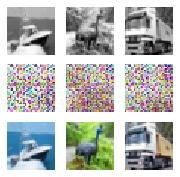

##############
For Epoch:1
Training Discriminator


In [0]:
for epoch in range(epochs):
  print("##############")
  print("For Epoch:"+str(epoch))
  
  g_loss = 0
  d_loss = 0
  
  print("Training Discriminator")
  
  i = shuffle(range(n_example))
  
  dis.trainable = True
  dis.compile(loss = "binary_crossentropy",optimizer = adams)
  
  for j in range(dis_updates):
      
    for b in range(batches):
        
      x_batch = x[i[b*batch_size:(b+1)*batch_size]]
      y_batch = y[i[b*batch_size:(b+1)*batch_size]]
      
      pre_batch = gen.predict(x_batch)
      
      d_loss += dis.train_on_batch([x_batch,y_batch],one)
      d_loss += dis.train_on_batch([x_batch,pre_batch],zero)
      
  print("Training Generator")
  
  dis.trainable = False
  combined.compile(loss  = "binary_crossentropy", optimizer = adams)  
  dis.compile(loss = "binary_crossentropy",optimizer = adams)
        
  for  j in range(gen_updates):
    
    for b in range(batches):
      
      x_batch = x[i[b*batch_size:(b+1)*batch_size]]
      y_batch = y[i[b*batch_size:(b+1)*batch_size]]
      
        
      #in case the mode collapse takes place....commenting next two lines might help.
      #if b%4==3:
        #gl,_,_ = combined.train_on_batch([x_batch,y_batch],[zero,one])  
      
      gl,_,_ = combined.train_on_batch([x_batch,y_batch],[one,one])
      g_loss += gl
      
  g_loss /= g_loss_factor
  d_loss /= d_loss_factor
      
  print("Discriminator Loss:"+str(d_loss))
  print("Generator loss:"+str(g_loss))
  
  genLoss.append(g_loss)
  disLoss.append(d_loss)
  
  # gen.save_weights("gdrive/My Drive/newGAN/Generator.h5")
  # dis.save_weights("gdrive/My Drive/newGAN/Discriminator.h5")
  


  plt_indices = np.random.randint(10,size=3)
  plt_a = x[plt_indices]
  plt_b = gen.predict(plt_a)
  plt_b = (plt_b+1)/2
  plt_c = (y[plt_indices]+1)/2
  fig = plot(plt_a,plt_b,plt_c,3)
  plt.show()
  plt.close(fig)
 





#for recieving mail on completion of training.
# server = smtplib.SMTP('smtp.gmail.com', 587)
# server.starttls()
# server.login("************@gmail.com", "*********")
 
# msg = "COLAB WORK FINISH ALERT!"
# server.sendmail("***********@gmail.com", "********@nirmauni.ac.in", msg)
# server.quit()

In [0]:
plt.plot(genLoss, c='r', label="Generator Loss")
plt.plot(disLoss, c='b', label="Discriminator Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

# files.download('gdrive/My Drive/newGAN/Generator.h5')
# files.download('gdrive/My Drive/newGAN/Discriminator.h5')

In [0]:
#for recieving mail on completion of training.
# server = smtplib.SMTP('smtp.gmail.com', 587)
# server.starttls()
# server.login("************@gmail.com", "*********")

# msg = "COLAB WORK FINISH ALERT!"
# server.sendmail("***********@gmail.com", "********@nirmauni.ac.in", msg)
# server.quit()

plt_indices = np.random.randint(1000,size=3)
plt_a = x_test[plt_indices]

# plt_b = gen.predict(plt_a)
# plt_c = y[plt_indices]
# fig = plot(plt_a,plt_b,plt_c,3)
# plt.show()
# plt.close(fig)
# plt_b = (plt_b + 1)*128
# print(np.min(plt_b-plt_c/255))